In [1]:
# 🧩 Cell 1: Setup Environment

!apt-get update -qq
!apt-get install -y -qq chromium-browser
!pip install -q selenium webdriver-manager pillow pandas matplotlib scikit-learn tensorflow==2.12.0 kaggle seaborn


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Preconfiguring packages ...
Selecting previously unselected package apparmor.
(Reading database ... 121703 files and directories currently installed.)
Preparing to unpack .../apparmor_3.0.4-2ubuntu2.4_amd64.deb ...
Unpacking apparmor (3.0.4-2ubuntu2.4) ...
Selecting previously unselected package squashfs-tools.
Preparing to unpack .../squashfs-tools_1%3a4.5-3build1_amd64.deb ...
Unpacking squashfs-tools (1:4.5-3build1) ...
Preparing to unpack .../libudev1_249.11-0ubuntu3.17_amd64.deb ...
Unpacking libudev1:amd64 (249.11-0ubuntu3.17) over (249.11-0ubuntu3.12) ...
Setting up libudev1:amd64 (249.11-0ubuntu3.17) ...
Selecting previously unselected package udev.
(Reading database ... 121903 files and directories currently installed.)
Preparing to unpack .../udev_249.11-0ubuntu3.17_amd64.deb ...
Unpacking 

In [2]:
# 🧩 Cell 2: Download Dataset
import os, zipfile

os.environ['KAGGLE_USERNAME'] = "YOUR_KAGGLE_USERNAME"
os.environ['KAGGLE_KEY'] = "YOUR_KAGGLE_KEY"

!kaggle datasets download -d zackyzac/phishing-sites-screenshot -p /content/
with zipfile.ZipFile("/content/phishing-sites-screenshot.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

!ls /content/dataset


Dataset URL: https://www.kaggle.com/datasets/zackyzac/phishing-sites-screenshot
License(s): MIT
 57% 115M/201M [00:00<00:00, 1.20GB/s]
100% 201M/201M [00:00<00:00, 948MB/s] 
screenshots


In [3]:
# 🧩 Cell 3: Build labels.csv + Generate Fake URLs
import pandas as pd, random
from pathlib import Path

# Correct possible_paths and directory names
possible_paths = [Path("/content/dataset/screenshots")] # Correct path to the screenshots directory
for p in possible_paths:
    if (p / "phishing_site_1").exists() and (p / "genuine_site_0").exists(): # Check for correct directory names
        data_root = p
        break
else:
    raise FileNotFoundError("❌ Could not find genuine_site_0/phishing_site_1 folders.")

rows = []
# Correct label_map
label_map = {"genuine_site_0": 0, "phishing_site_1": 1}
for lbl, val in label_map.items():
    # Ensure the directory exists before trying to glob
    label_dir = data_root / lbl
    if label_dir.exists():
        for img in list((label_dir).glob("*.png")) + list((label_dir).glob("*.jpg")):
            rows.append({"filename": str(img), "label": val})
    else:
        print(f"Warning: Directory {label_dir} not found.")


df = pd.DataFrame(rows)

# ✅ Fix: Generate realistic synthetic URLs (to remove leakage)
def generate_fake_url(label):
    if label == 1:  # phishing
        words = ["banklogin", "secure-update", "account-verify", "password-reset", "freebonus", "offerclaim"]
        domain = random.choice(words)
        return f"https://{domain}{random.randint(10,999)}.info/login"
    else:  # legitimate
        sites = ["google", "wikipedia", "github", "linkedin", "nytimes", "amazon"]
        domain = random.choice(sites)
        return f"https://{domain}{random.randint(10,999)}.com/home"

df["url_text"] = df["label"].apply(generate_fake_url)

df.to_csv("/content/labels.csv", index=False)
print(f"✅ labels.csv created with {len(df)} samples and realistic URLs")
display(df.head())

✅ labels.csv created with 1697 samples and realistic URLs


,filename,label,url_text
0,/content/dataset/screenshots/genuine_site_0/ge...,0,https://amazon38.com/home
1,/content/dataset/screenshots/genuine_site_0/ge...,0,https://google895.com/home
2,/content/dataset/screenshots/genuine_site_0/ge...,0,https://wikipedia571.com/home
3,/content/dataset/screenshots/genuine_site_0/ge...,0,https://amazon149.com/home
4,/content/dataset/screenshots/genuine_site_0/ge...,0,https://amazon802.com/home


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def prepare_generators(csv_path, batch_size=32, img_size=(224,224)):
    df = pd.read_csv(csv_path)
    # Convert 'label' column to string type for flow_from_dataframe with class_mode='binary'
    df['label'] = df['label'].astype(str)
    train_df,test_df=train_test_split(df,test_size=0.4,stratify=df['label'],random_state=42)
    val_df,test_df=train_test_split(test_df,test_size=0.5,stratify=test_df['label'],random_state=42)
    train_gen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=15,
                                 zoom_range=0.2,
                                 brightness_range=[0.8,1.2],
                                 horizontal_flip=True)
    val_gen=ImageDataGenerator(rescale=1./255)
    test_gen=ImageDataGenerator(rescale=1./255)
    train_flow=train_gen.flow_from_dataframe(train_df,x_col='filename',y_col='label',
                                             target_size=img_size,class_mode='binary',
                                             batch_size=batch_size,shuffle=True)
    val_flow=val_gen.flow_from_dataframe(val_df,x_col='filename',y_col='label',
                                         target_size=img_size,class_mode='binary',
                                         batch_size=batch_size,shuffle=False)
    test_flow=test_gen.flow_from_dataframe(test_df,x_col='filename',y_col='label',
                                           target_size=img_size,class_mode='binary',
                                           batch_size=batch_size,shuffle=False)
    return train_flow,val_flow,test_flow

Found 1018 validated image filenames belonging to 2 classes.
Found 339 validated image filenames belonging to 2 classes.
Found 340 validated image filenames belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5902 - loss: 0.8754

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5909 - loss: 0.8735 - val_accuracy: 0.6755 - val_loss: 0.6427 - learning_rate: 3.0000e-04
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6423 - loss: 0.7322 - val_accuracy: 0.6637 - val_loss: 0.6457 - learning_rate: 3.0000e-04
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6360 - loss: 0.7387 - val_accuracy: 0.6755 - val_loss: 0.6270 - learning_rate: 3.0000e-04
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6771 - loss: 0.6075 - val_accuracy: 0.6755 - val_loss: 0.6301 - learning_rate: 3.0000e-04
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6283 - loss: 0.7156 - val_accuracy: 0.6755 - val_loss: 0.6437 - learning_rate: 3.0000e-04
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6441 - loss: 0.6480 - val_accuracy: 0.6755 - val_loss: 0.6842 - learning_rate: 3.0000e-04
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6799 - loss: 0.5933 - v

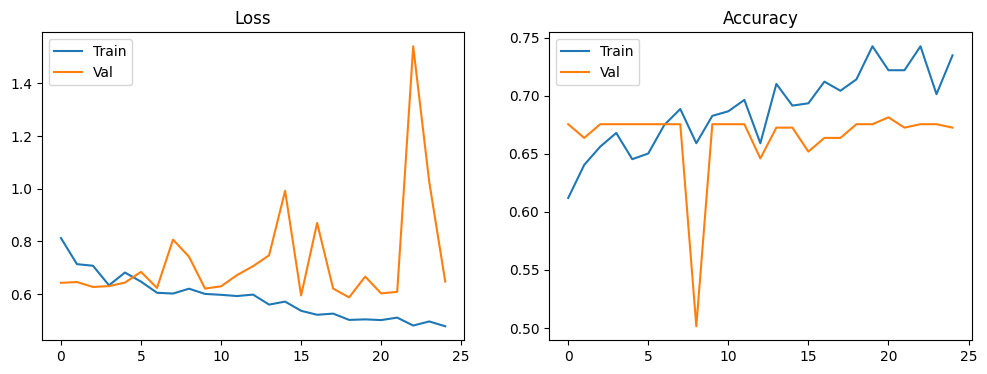

In [7]:
# 🧩 Upgraded ResNet-50 Fine-Tuning Model
import tensorflow as tf
from tensorflow.keras import layers, models

def build_resnet_finetune(input_shape=(224,224,3), unfreeze_from=140):
    base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # Unfreeze top layers for fine-tuning
    for layer in base.layers[:unfreeze_from]:
        layer.trainable = False
    for layer in base.layers[unfreeze_from:]:
        layer.trainable = True

    inputs = tf.keras.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model


# 🧩 Train upgraded ResNet-50
train_flow, val_flow, test_flow = prepare_generators("/content/labels.csv", batch_size=32, img_size=(224, 224)) # Added img_size=(224, 224)

model = build_resnet_finetune(input_shape=(224,224,3), unfreeze_from=140)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("resnet_finetuned.keras", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
]

history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=55,
    callbacks=callbacks,
    verbose=1
)

# Plot curves
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
plt.title('Loss'); plt.legend(['Train','Val'])
plt.subplot(1,2,2)
plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy'])
plt.title('Accuracy'); plt.legend(['Train','Val'])
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
📊 ResNet-50 Metrics: {'Accuracy': 0.6911764705882353, 'Precision': 0.6470588235294118, 'Recall': 0.1, 'F1': 0.1732283464566929, 'AUC': np.float64(0.73)}


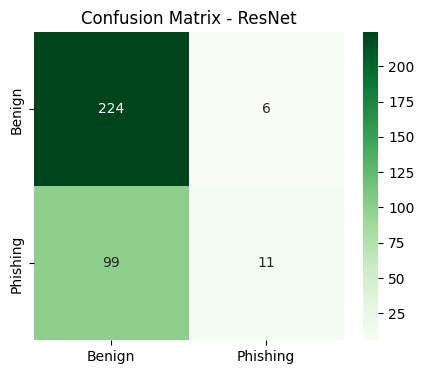

In [9]:
# 🧩 Cell 7: Evaluate & Visualize
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

y_true = test_flow.classes
y_prob = model.predict(test_flow) # Changed resnet_model to model
y_pred = (y_prob.ravel() >= 0.5).astype(int)

metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1": f1_score(y_true, y_pred),
    "AUC": roc_auc_score(y_true, y_prob)
}
print("📊 ResNet-50 Metrics:", metrics)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Benign","Phishing"], yticklabels=["Benign","Phishing"])
plt.title("Confusion Matrix - ResNet"); plt.show()

In [19]:
import tensorflow as tf

# Save the fine-tuned multimodal fusion model
model.save('fusion_model.keras')
print("✅ Multimodal fusion model saved as 'fusion_model_basic.keras'")

✅ Multimodal fusion model saved as 'fusion_model_basic.keras'


Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7236 - loss: 0.5161 - val_accuracy: 0.6932 - val_loss: 0.5849 - learning_rate: 1.0000e-05
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7342 - loss: 0.4952 - val_accuracy: 0.7080 - val_loss: 0.5878 - learning_rate: 1.0000e-05
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7100 - loss: 0.5235 - val_accuracy: 0.6873 - val_loss: 0.6066 - learning_rate: 1.0000e-05
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7673 - loss: 0.4611 - val_accuracy: 0.7080 - val_loss: 0.6068 - learning_rate: 5.0000e-06
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7140 - loss: 0.5176 - val_accuracy: 0.7080 - val_loss: 0.6069 - learning_rate: 5.0000e-06


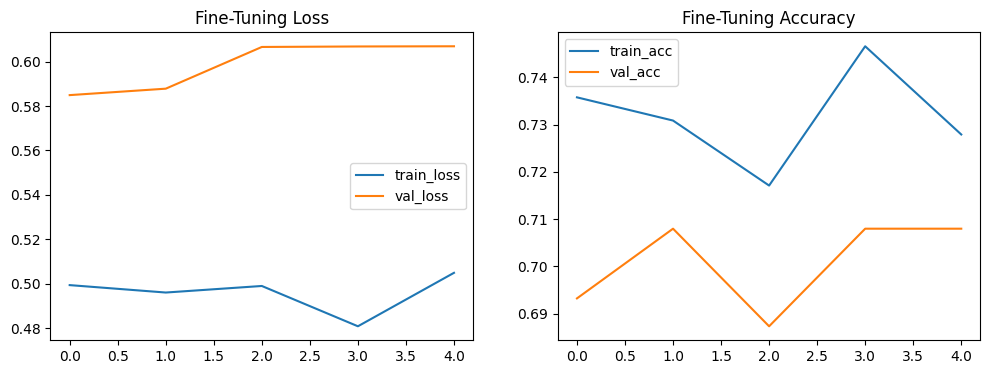

In [12]:
# 🧩 Phase-2: Full ResNet-50 Fine-Tuning
import tensorflow as tf

# Unfreeze all layers for full fine-tuning
for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("resnet_finetuned_full.keras", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
]

fine_history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

# Plot fine-tuning results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(fine_history.history['loss'], label='train_loss')
plt.plot(fine_history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Fine-Tuning Loss')

plt.subplot(1,2,2)
plt.plot(fine_history.history['accuracy'], label='train_acc')
plt.plot(fine_history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Fine-Tuning Accuracy')
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 878ms/step
📊 Fine-Tuned ResNet Metrics: {'Accuracy': 0.6764705882352942, 'Precision': 0.5, 'Recall': 0.23636363636363636, 'F1': 0.32098765432098764, 'AUC': np.float64(0.7384189723320158)}


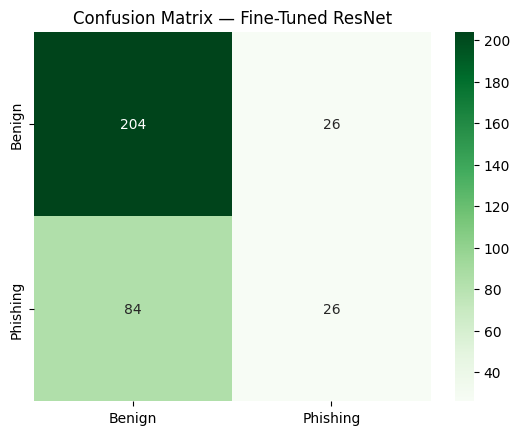

In [13]:
# 🧠 Evaluate fine-tuned ResNet model
import numpy as np, seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_true = test_flow.classes
y_prob = model.predict(test_flow)
y_pred = (y_prob.ravel() >= 0.5).astype(int)

resnet_metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1": f1_score(y_true, y_pred),
    "AUC": roc_auc_score(y_true, y_prob)
}
print("📊 Fine-Tuned ResNet Metrics:", resnet_metrics)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Benign","Phishing"], yticklabels=["Benign","Phishing"])
plt.title("Confusion Matrix — Fine-Tuned ResNet"); plt.show()


In [14]:
import tensorflow as tf

# Save the fine-tuned ResNet model from Phase 2
model.save('resnet_finetuned_full.keras')
print("✅ Fine-tuned ResNet model (Phase 2) saved as 'resnet_finetuned_full.keras'")

✅ Fine-tuned ResNet model (Phase 2) saved as 'resnet_finetuned_full.keras'


In [15]:
# 🧩 Cell 8: Lexical Feature Extraction (No Leakage)
import re, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

def extract_url_features(csv_path, max_features=500):
    df = pd.read_csv(csv_path)
    df['url_text'] = df['url_text'].astype(str)
    def count_digits(u): return sum(c.isdigit() for c in u)
    def count_special(u): return len(re.findall(r'[^\w]', u))
    df['length']=df['url_text'].apply(len)
    df['digits']=df['url_text'].apply(count_digits)
    df['specials']=df['url_text'].apply(count_special)
    tfidf=TfidfVectorizer(analyzer='char',ngram_range=(2,5),max_features=max_features)
    X_tfidf=tfidf.fit_transform(df['url_text']).toarray()
    meta=df[['length','digits','specials']].values
    X_meta=StandardScaler().fit_transform(meta)
    X_lex=np.hstack([X_tfidf,X_meta])
    print("Lexical feature shape:", X_lex.shape)
    return df, X_lex


Lexical feature shape: (1697, 85)
Found 1697 validated image filenames belonging to 2 classes.
✅ Loaded weights from fine-tuned ResNet model.
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.6155 - loss: 0.6815 - val_accuracy: 0.4248 - val_loss: 0.6695 - learning_rate: 1.0000e-04
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - accuracy: 0.7542 - loss: 0.4585 - val_accuracy: 0.7021 - val_loss: 0.5214 - learning_rate: 1.0000e-04
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - accuracy: 0.8160 - loss: 0.3703 - val_accuracy: 0.8584 - val_loss: 0.4789 - learning_rate: 1.0000e-04
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - accuracy: 0.8867 - loss: 0.2930 - val_accuracy: 0.8643 - val_loss: 0.4721 - learning_rate: 1.0000e-04
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.9199 - loss: 0.2376 - val_accuracy: 0.9499 - val_loss: 0.4973 - learning_rate: 1.0000e-04
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step - accuracy: 0.9407 - l

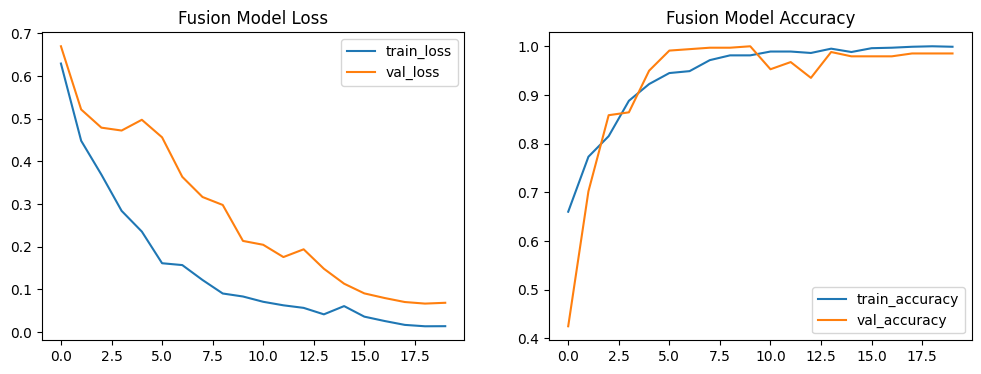

In [16]:
# 🧩 Multimodal Fusion — Fine-Tuned ResNet + URL Lexical Features
import re, numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
import tensorflow as tf # Ensure tensorflow is imported
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # Import metrics for evaluation


def extract_url_features(csv_path, max_features=82):
    df = pd.read_csv(csv_path)
    df['url_text'] = df['url_text'].astype(str)
    def count_digits(u): return sum(c.isdigit() for c in u)
    def count_special(u): return len(re.findall(r'[^\w]', u))
    df['length']=df['url_text'].apply(len)
    df['digits']=df['url_text'].apply(count_digits)
    df['specials']=df['url_text'].apply(count_special)
    tfidf=TfidfVectorizer(analyzer='char',ngram_range=(2,5),max_features=max_features)
    X_tfidf=tfidf.fit_transform(df['url_text']).toarray()
    meta=df[['length','digits','specials']].values
    X_meta=StandardScaler().fit_transform(meta)
    X_lex=np.hstack([X_tfidf,X_meta])
    print("Lexical feature shape:", X_lex.shape)
    return df, X_lex

# Prepare lexical + image data
df, X_lex = extract_url_features("/content/labels.csv", max_features=82)
df['label'] = df['label'].astype(str) # Convert labels to string for flow_from_dataframe
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
flow = datagen.flow_from_dataframe(df, x_col='filename', y_col='label',
                                   target_size=(224,224), class_mode='binary',
                                   batch_size=32, shuffle=False)
X_img = np.vstack([flow[i][0] for i in range(len(flow))])
# y = flow.classes # This gives integer labels, which is not needed for splitting when using df

# Get integer labels from the dataframe for splitting
y = df['label'].astype(int).values


n = min(len(X_img), len(X_lex))
X_img, X_lex, y = X_img[:n], X_lex[:n], y[:n]

# Split data into training, validation, and test sets
Xi_train, Xi_temp, Xl_train, Xl_temp, y_train, y_temp = train_test_split(
    X_img, X_lex, y, test_size=0.4, random_state=42, stratify=y)

Xi_val, Xi_test, Xl_val, Xl_test, y_val, y_test = train_test_split(
    Xi_temp, Xl_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Build fusion model
img_in = tf.keras.Input(shape=(224,224,3))
# Load ResNet50 base with weights from the fine-tuned model (assuming 'model' is the fine-tuned ResNet model from cell 6)
# model.get_layer(index=1) assumes the ResNet50 base is the second layer in the fine-tuned model
# A more robust way is to get the layer by name, assuming the name is 'resnet50'
try:
    resnet_base_layer = model.get_layer('resnet50')
    base = tf.keras.applications.ResNet50(weights=None, include_top=False, input_tensor=img_in)
    base.set_weights(resnet_base_layer.get_weights())
    print("✅ Loaded weights from fine-tuned ResNet model.")
except ValueError:
    print("⚠️ Could not find 'resnet50' layer in the fine-tuned model. Initializing ResNet50 with ImageNet weights.")
    base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=img_in)
    # Freeze base initially
    base.trainable = False


x = layers.GlobalAveragePooling2D()(base.output)
x = layers.BatchNormalization()(x) # Added BatchNormalization
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

lex_in = tf.keras.Input(shape=(X_lex.shape[1],))
y_ = layers.Dense(128, activation='relu')(lex_in)
y_ = layers.Dropout(0.4)(y_)

combined = layers.Concatenate()([x, y_])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dropout(0.3)(z)
out = layers.Dense(1, activation='sigmoid')(z)

fusion_model = tf.keras.Model([img_in, lex_in], out)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # Added optimizer
fusion_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) # Corrected compile call

# Train the model
# Added EarlyStopping and ReduceLROnPlateau callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history_fusion = fusion_model.fit(
    [Xi_train, Xl_train], y_train,
    validation_data=([Xi_val, Xl_val], y_val),
    epochs=20, # Increased epochs
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


# Evaluate the model and calculate metrics
loss, accuracy = fusion_model.evaluate([Xi_test, Xl_test], y_test, verbose=0)
y_pred_prob = fusion_model.predict([Xi_test, Xl_test])
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate multimodal metrics
multi_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred_prob)
}

print("📊 Multimodal Metrics:", multi_metrics)

# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fusion.history['loss'], label='train_loss')
plt.plot(history_fusion.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Fusion Model Loss')

plt.subplot(1, 2, 2)
plt.plot(history_fusion.history['accuracy'], label='train_accuracy')
plt.plot(history_fusion.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Fusion Model Accuracy')
plt.show()

In [20]:
import tensorflow as tf

# Save the fine-tuned multimodal fusion model
fusion_model.save('fusion_model.keras')
print("✅ Multimodal fusion model saved as 'fusion_model.keras'")

✅ Multimodal fusion model saved as 'fusion_model.keras'


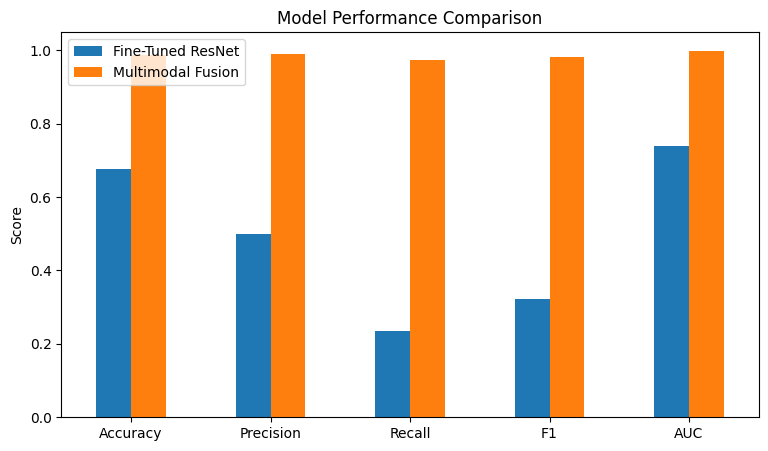

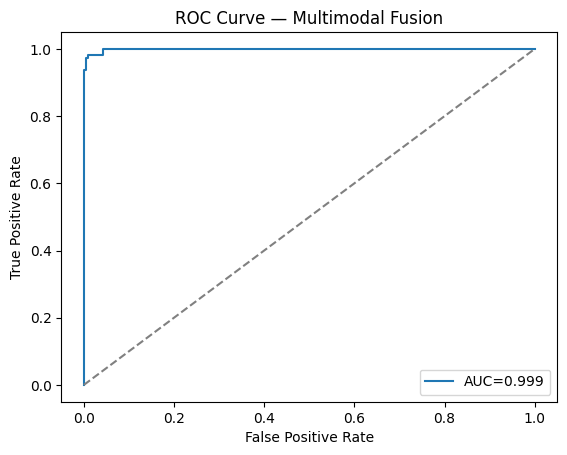

In [21]:
# 🧩 Visualization — Compare CNN vs Multimodal
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score

# Compare performance
compare_df = pd.DataFrame([resnet_metrics, multi_metrics], index=["Fine-Tuned ResNet","Multimodal Fusion"]) # Changed fusion_metrics to multi_metrics
compare_df.T.plot(kind='bar', figsize=(9,5), title="Model Performance Comparison", rot=0)
plt.ylabel("Score"); plt.show()

# ROC Curve for fusion
# Assuming y_test and y_pred_prob are available from the multimodal model evaluation
if 'y_test' in locals() and 'y_pred_prob' in locals():
    fpr,tpr,_ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr,tpr,label=f"AUC={roc_auc_score(y_test,y_pred_prob):.3f}")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — Multimodal Fusion"); plt.legend(); plt.show()
else:
    print("y_test or y_pred_prob not found. Skipping ROC curve for multimodal fusion.")